# CNNs

Feedforward (or fully connected) networks lead to a number of parameters. Inspired by the human (or cat's in fact) visual cortex, convolutional neural networks (CNNs) are primarily used for the Computer Vision tasks.

>**Note:** A special thanks to the authors of **[Convolution Arithmetic](https://github.com/vdumoulin/conv_arithmetic)** tutorial for the animations.



## Convolution Operation

Convolution operation is inspired from Digital Signal Processing (its ok if you don't know about it), where we convolve a filter with the input signal.

Luckily, its much easier to understand it for images in 2D.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)



There are a number of ways of performing the convolution. Regardless of the type, in convolution, we have:

- Input image ($I$) having dimensions $m \times n$.
- Convolution filter ($F$) having dimensions $f \times f$. Not only they are square, but usually its common to have them in an odd order: $3 \times 3, 5 \times 5$, etc.
- And output/resultant image ($O$) having dimensions $x \times y$. We will look more into it soon.

For applying convolution, we place the filter on the top left and calculate the weighted sum of the underlying (input image's) pixels as:

$$s = \sum_{i,j=0}^{f-1}  I_{p,q}F_{i,j}$$

Dont be worried by the above equation (yeah, its not perfectly written). It just means that we take the product of first pixel with the filter's first pixel, second's with the filter's second pixel and so on.

As an example: We have a filter matrix as:

<TODO: insert matrices for both filter and image>



### Output image has smaller resolution

As we can see in the gif above, we can't convolve beyond the last column, which means that output image will be _slimmer_ than the input one. And similarly, we can't convolve beyond the last row, which means it will be _shorter_ as well.

If we look closely, the output will have 2 columns less than the input one. Same for the rows as well.

In other words:

$$x = m - f +1$$

And similarly,

$$y = n -f +1$$

Collectively,

$$(x,y) = (m-f+1,n-f+1)$$

#### Example

We can better understand it with an example:

Suppose, we have an image of $28 \times 28$ (normal MNIST images) and want to apply $3 \times 3$ filter on it. Resultant image's dimensions would be:

$$(x,y) = (28-3+1,28-3+1)$$

$$ = (26,26)$$

Lets verify it in the code:

In [ ]:
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name','cpu')

We can simply declare the image and filter as the JAX arrays.

In [ ]:
I = jnp.ones((28,28))
F = jnp.ones((3,3))

There are a number of ways of taking convolutions in JAX. I prefer the LAX method (Personally, I prefer PyTorch for this), `conv_general_dilated`.

Its syntax is:

`<output> = conv_general_dilated(<input images>,<filter>,....)`

In [ ]:
import jax.lax as lax
O = lax.conv_general_dilated(I[None, None], F[None, None], (1,1),[(0,0),(0,0)])
(O.shape[2],O.shape[3])

(26, 26)

Why did I use `[None,None]` above or took only the last 2 parts of the `O`'s shape? Lets delay it for the time being.

What is in the dots? We are going to study that now:

### Padding

Often there are cases where we need to add the padding with the input image to ensure that filter is applied throughout (and hence less or no shrinkage in size).

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/arbitrary_padding_no_strides.gif)

In such a case, resultant image will be _stretched_ from both left and right (for width) and top and bottom (for height).

If we have a padding of $1$ on each side, it means we will have an addition of $2$ in $x$ and $2$ in $y$ as well. Generalizing it for $p$ size of padding, we will get:

$$(x,y) = (m-f+2p+1,n-f+2p+1)$$

#### Example

Applying a padding of 2 for the above example, we get:

$$(x,y) = (28-3+2(2)+1,28-3+2(2)+1)$$

$$ = (30,30)$$

Whoa! The output is bigger than the input. Rare, but theoretically it's still possible. We can confirm that too.

Since all of the settings are same as the above example. We just need to call the **`conv_general_dilated()`** again.

I just skipped its last two arguments. I will still skip the first one for a few mins, but the second one shows the padding. Lets set it accordingly and verify the effect on the output:

In [ ]:
O = lax.conv_general_dilated(I[None, None], F[None, None], (1,1),[(2,2),(2,2)])
(O.shape[2],O.shape[3])

(30, 30)

### Strides

There can be scenarios where we have low computational resources and bigger images. In such cases, its useful to shrink the size considerably. For that, we can choose to filter by taking a jump or a stride rather than applying it consecutively.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)


In such a case(s), size decreases by a factor. If we take the stride of 2 (like in the example above), it will shrink the output by half. Similarly, if we do it by 3, it will be one-third and so on. Mathematically,

$$(x,y) = (\frac{m-f}{s}+1,\frac{n-f}{s}+1)$$

**Note:** Please note that stride is applied in both horizontal and vertical traversing.

>It is the 3rd argument in the convolution function we have been using.

#### Strides with Padding

We can make it insane by having both strides and padding combined (doesn't make any sense to me, though).

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif)

In this scenario, we will have full equation:

$$(x,y) = (\frac{m-f+2p}{s}+1,\frac{n-f+2p}{s}+1)$$

Lets round it off by last example in which we are using the same padding ($2\times2$) as above with stride of $2$:

$$(x,y) = (\frac{28-3+2(3)}{2}+1,\frac{28-3+2(3)}{2}+1)$$

$$=(16,16)$$

In [ ]:
O = lax.conv_general_dilated(I[None, None], F[None, None], (2,2),[(3,3),(3,3)])
(O.shape[2],O.shape[3])
O.shape

(1, 1, 16, 16)

## Pooling

Usually pixels in a local region are pretty much similar (even more true for the bigger images), hence we can even simplify the scenario by just summing them up without any weights. In this case, our filter is a fixed function and doesn't need to learn any weights; hence a relaxer backprop.

We can have these pooling operations:

- Average
- Max – Pick the maximum of the pixels under the filter.

If you can think of any other pooling operator, feel free to try one. Actually, it would be a good practice.

**Note:** Pooling is usually applied in a non-overlapping way. JAX allows us to set the strides manually too using the `strides` attribute.

---

<To be continued>

### Implementation

JAX doesn't have an implementation (though its not tough to make it ourselves). PyTorch, Keras and Tensorflow provide it though.

## Convolution with Channels

If we recall, a colour image is 2D but it has 3 channels (RGB) as well, meaning our input is overall a 3D tensor. That'swhy we had two other dimensions other than the Height and the Width.

What about the other dimension we skipped above? Its answer will be found in the starting lectures of ML (when instructors switch from GD to SGD and finally to Batched GD). Its pretty rare to use any of the extremes of SGD or GD, hence we input the data (including the images) in a batched form, making it a 4D combination (i.e, a tuple).

4D can be hard to visualize for us, but for computers (and NumPy/JAX/PyTorch in particular) is as simple as normal 2D stuff.

So finally, our input would be:

$$N \times C \times H \times W$$

Where, $N$ is number of images in the input batch, $C$ is the number of channels and $H, W$ are height and width, respectively.

---



### How does Convolution Work with Channels

For multiple channels, convolution works pretty much the same way you are applying it normally for 2D (as we have had so far).

The only difference would be that.. Umm let me explain it with an example.

Lets suppose we have 3 channels (simply RGB). Usually, the number of filters is equal to the number of channels, so **we have 3 channels and 3 filters**.

Now, we will take all the 3 channels separately and apply each filter on the respective channel. Obviously, each channel-filter pair will have a corresponding output.

Let's see it using the nice animation (Credits: **[CS231n, Stanford](https://cs231n.github.io/convolutional-networks/#norm)**).

In [ ]:
#Code credits: ChatGPT
from IPython.display import display, HTML

iframe_code = f'<iframe src="https://cs231n.github.io/assets/conv-demo/index.html" width="800" height="700"></iframe>'
display(HTML(iframe_code))

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<div class="fig figcenter fighighlight">
  
  <iframe src="https://cs231n.github.io/assets/conv-demo/index.html" width="100%" height="400px;" style="border:none;"></iframe>
  
  <div class="figcaption"></div>

</div>

## PyTorch Implementation

We can implement convolution in PyTorch as **`nn.Conv2D()`**.

In [ ]:
import torch.nn as nn

A = nn.Conv2d(3,3,3)
A

Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
import torch

input = torch.ones((1,3,28,28))

B = A(input)
B.shape

torch.Size([1, 3, 26, 26])

This is the first time I am directly running a code without explaining it. Now, let me get back to it. PyTorch's function takes the following arguments:

- Number of input channels
- Number of output image's channels too
- Filter Size – provide a normal number `n` and it will convert it into a `(n,n)` tuple automatically (like it done above).
- And other arguments like stride or pooling.

Please feel free to check it further.

>**Note:** Technically, its not convolution, but is correlation instead.

## Convolution in 1D

Those with DSP/EE background can realize that convolution originally came out of the DSP context where we take a signal and convolve it with a filter to take its _weighted summary_.

Lets consider some of its examples too:


In [ ]:
f = jnp.arange(1,11)
g = jnp.arange(-20,21)

Simply convolve them:

In [ ]:
output = jnp.convolve(f,g)

We can better explain it with the plot.

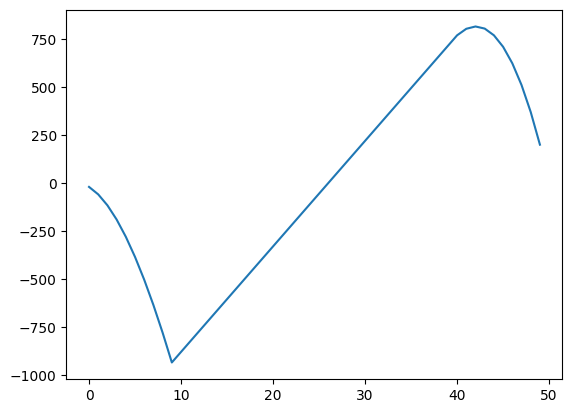

In [ ]:
import matplotlib.pyplot as plt

plt.plot(output)

### Example 2 - Sine Wave

What's the point of convolutions and signals when we don't mention our fav one?

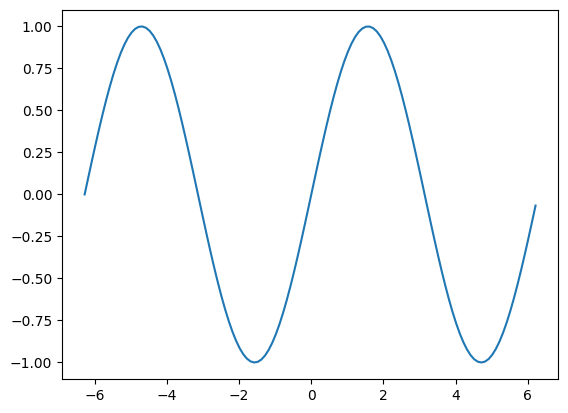

In [ ]:
a = jnp.arange(-2*jnp.pi,2*jnp.pi,0.1)
b = jnp.sin(a)
plt.plot(a,b)

Lets convolve it with – say exponential function.

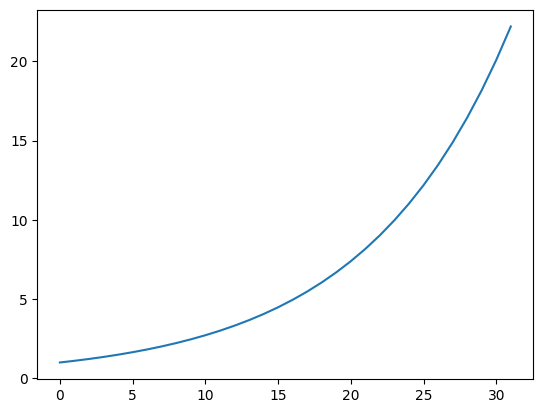

In [ ]:
c = jnp.arange(0,jnp.pi,0.1)
d = jnp.exp(c)
plt.plot(d)

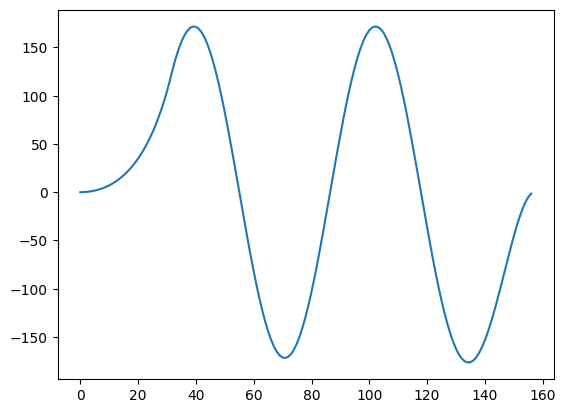

In [ ]:
e = jnp.convolve(b,d)
plt.plot(e)

### Example 3 - Sine and Cosine

Lets convolve them together. That would have made Euler happy (or frustrated) maybe.

In [ ]:
x_data = jnp.linspace(-jnp.pi,jnp.pi,100)
y_data = jnp.sin(x_data)
z_data = jnp.cos(x_data)
convolution_ans = jnp.convolve(y_data,z_data)

Lets plot it

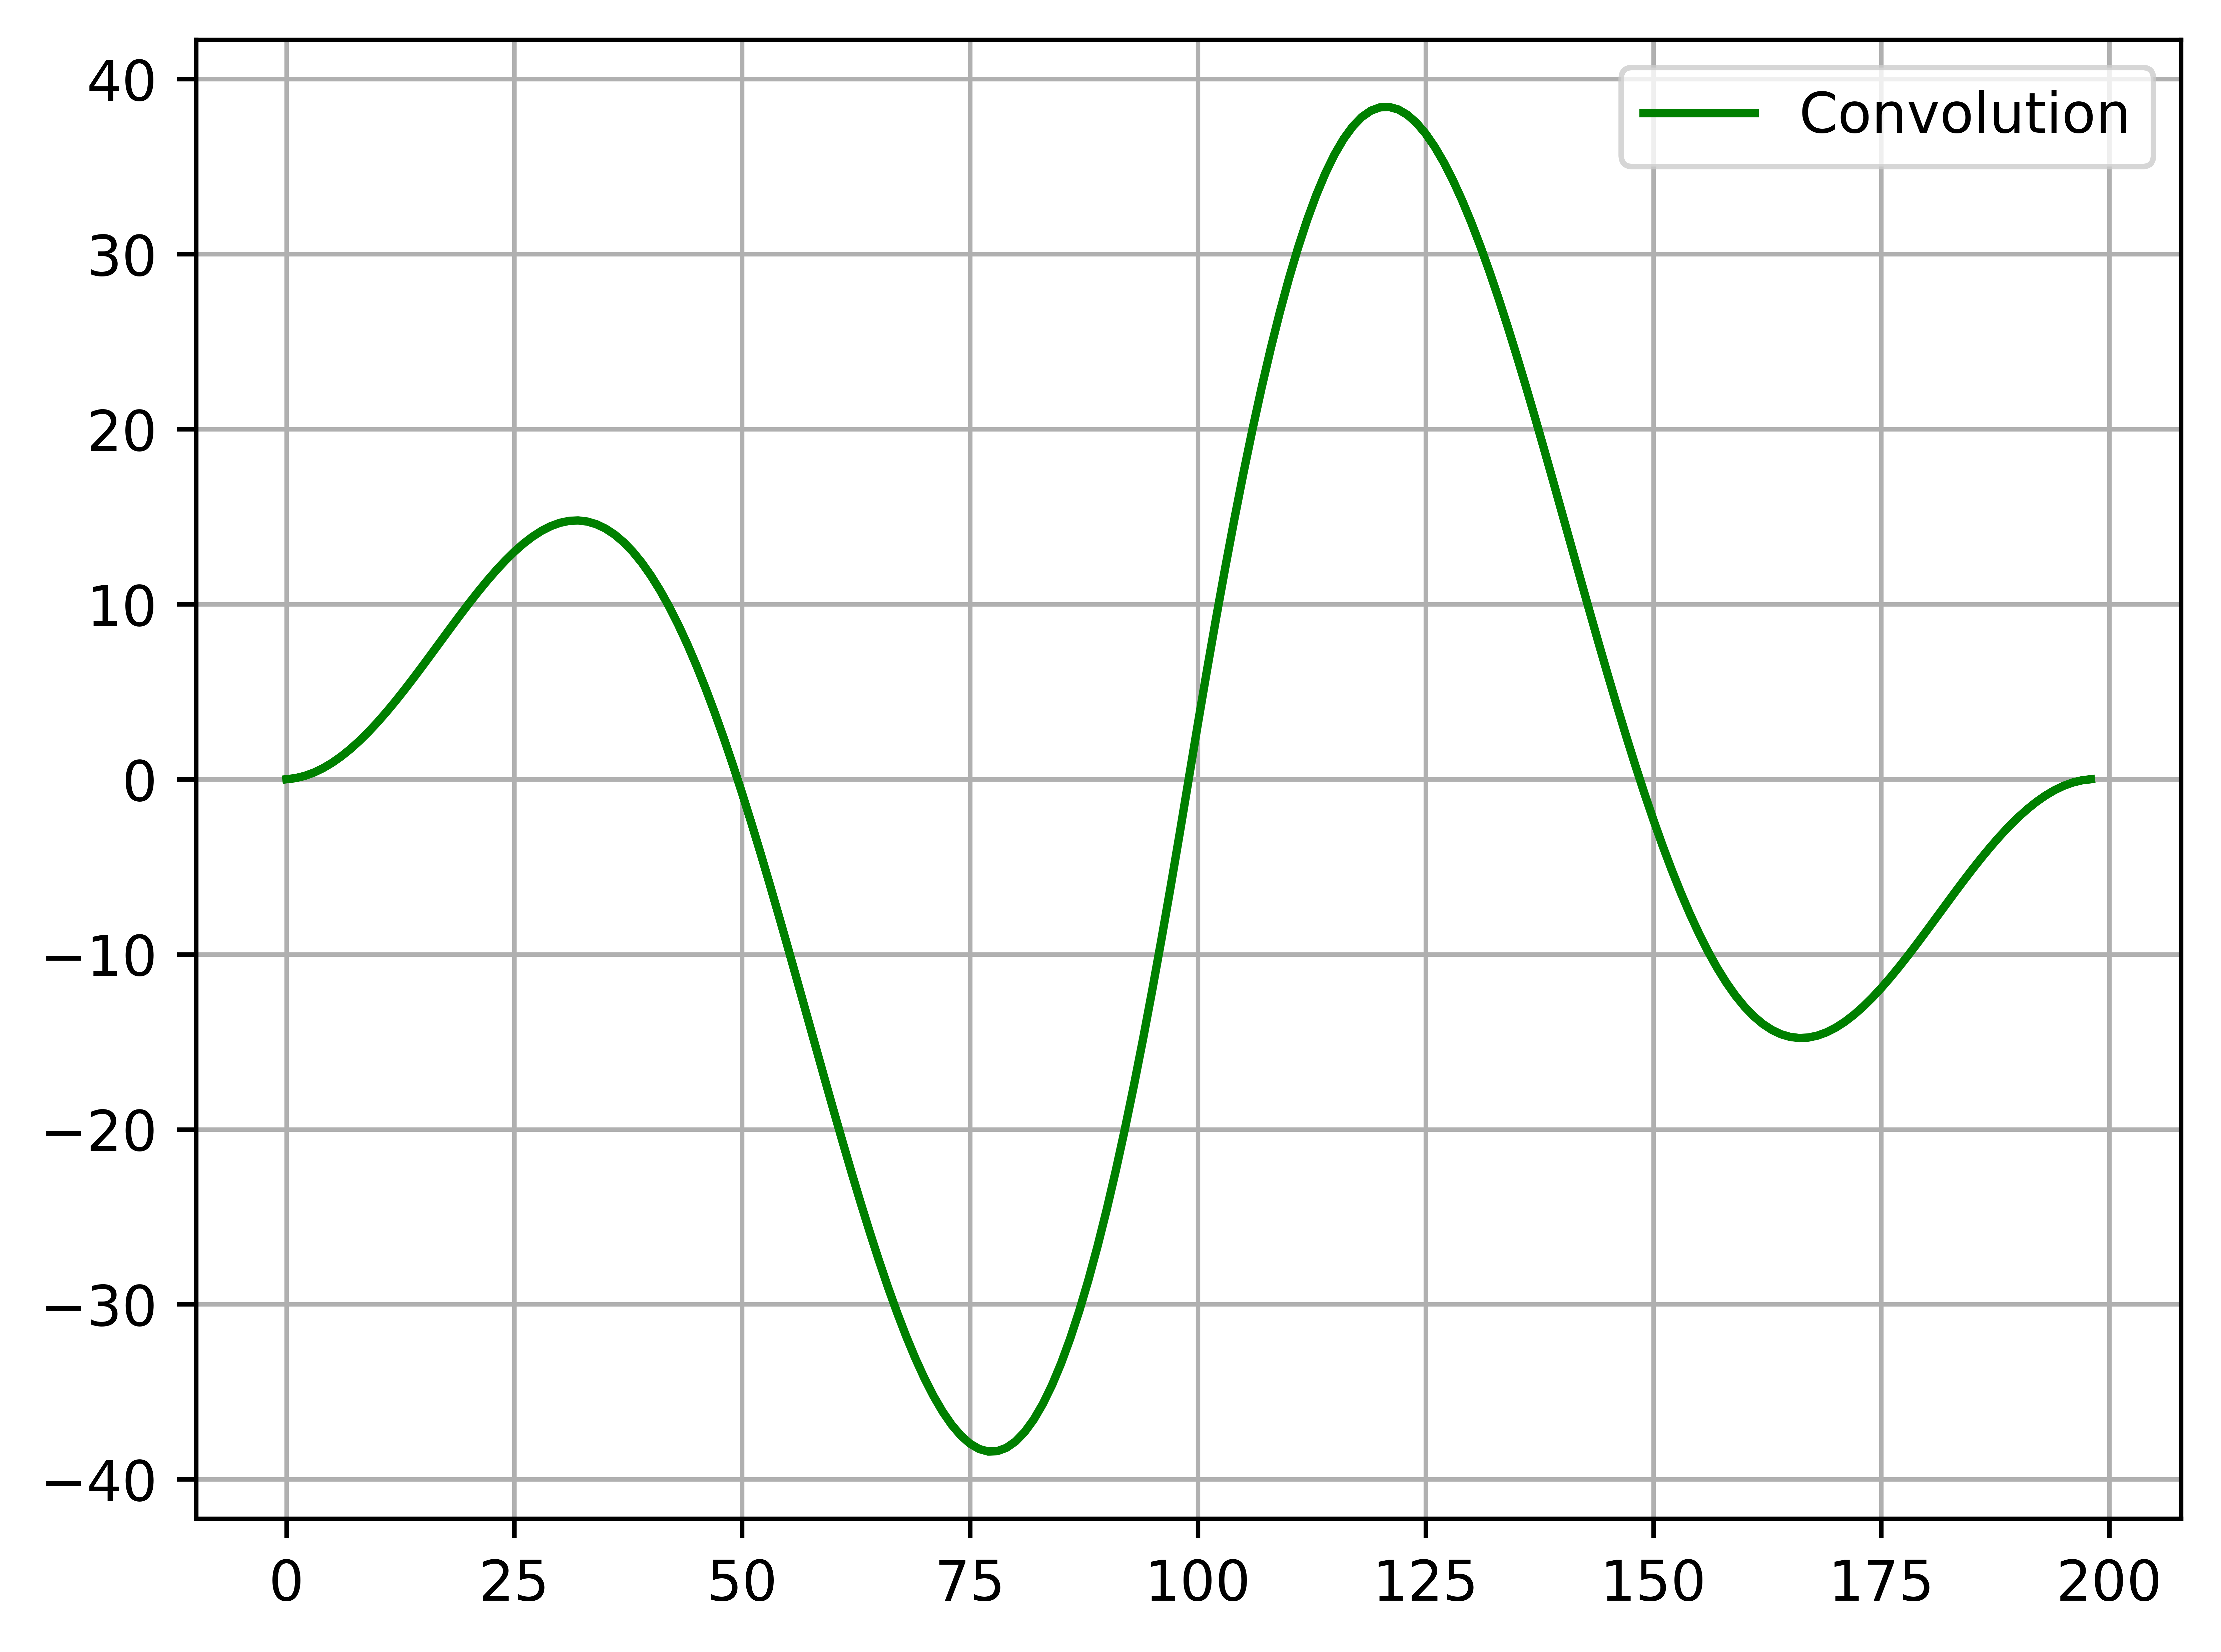

In [ ]:
fig, axe = plt.subplots(dpi=1200)
axe.plot(convolution_ans,color='g')
axe.legend(['Convolution'])
axe.grid()

I am going to paste this larger than life as a poster somewhere. Ciao!

## Implementation of Convolution Excercise

Lets try to implement convolution ourselves.

In [ ]:
I = jnp.ones((200,300))
m = I.shape[0]
n = I.shape[1]
#m,n = I.shape
print(m)
print(n)

200
300


In [ ]:
I[100][150]

Array(1., dtype=float32)

In [ ]:
def Conv(I,F):
  m = I.shape[0]
  n = I.shape[1]
  O = jnp.ones((m-f+1,n-f+1))
  for i in range(?,?):
    for j in range(?,?):
      #Algorithm: Take the 3x3 slice of the image and take the inner product with F
      inputSlice = I[?][?]
      convAnswer = jnp.dot(F,inputSlice)
      O[?][?] = convAnswer

  return O

## Credits

- **[Convolution Arithmetic](https://github.com/vdumoulin/conv_arithmetic)**
- **[CS231n, Stanford](https://cs231n.github.io/convolutional-networks/)**
- JAX and PyTorch Documentations